In [1]:
from tensorflow import keras
from tensorflow.keras import layers,models,optimizers,metrics
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import numpy as np
import time

In [2]:
from sklearn.metrics import fbeta_score
from sklearn.metrics import roc_curve,auc

In [3]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

In [4]:
# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

In [5]:
# train_dir = '/kaggle/input/case2-data/Case2_XRay/train/'
# test_dir = '/kaggle/input/case2-data/Case2_XRay/test/'
# validation_dir = '/kaggle/input/case2-data/Case2_XRay/validation/'

In [6]:
train_dir = 'Case2_XRay/train/'
test_dir = 'Case2_XRay/test/'
validation_dir = 'Case2_XRay/validation/'

In [7]:
train_datagen = ImageDataGenerator(rescale=1./255,
                                  rotation_range=40,
                                  width_shift_range=0.2,
                                  height_shift_range=0.2,
                                  shear_range=0.2,
                                  zoom_range=0.2,
                                  horizontal_flip=True,
                                  fill_mode='nearest'
                                 )
test_datagen = ImageDataGenerator(rescale=1./255)
validation_datagen = ImageDataGenerator(rescale=1./255)

In [8]:
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size = (150,150),
    batch_size = 439,
    class_mode = "binary")

validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    target_size = (150,150),
    batch_size = 293,
    shuffle = False,
    class_mode = "binary")

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size = (150,150),
    batch_size = 293,
    shuffle = False,
    class_mode = "binary")

Found 3512 images belonging to 2 classes.
Found 1172 images belonging to 2 classes.
Found 1172 images belonging to 2 classes.


# Model 1

In [9]:
model = models.Sequential()
model.add(layers.Conv2D(32,(3,3),activation = 'relu', input_shape = (150,150,3)))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(32,(3,3),activation = 'relu'))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(32,(3,3),activation = 'relu'))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(32,(3,3),activation = 'relu'))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Flatten())
model.add(layers.Dense(512,activation='relu'))
model.add(layers.Dense(1,activation='sigmoid'))

# model.summary()

In [10]:
model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr = 1e-4),
              metrics = [metrics.FalseNegatives(),metrics.SensitivityAtSpecificity(0.9),'acc']
             )

In [11]:
start_time = time.time()
history = model.fit_generator(train_generator,
                              steps_per_epoch = 8,
                              verbose = 0,
                              epochs = 8,
                              validation_data = validation_generator,
                              validation_steps = 4,
            )
#model.save('case2_run_1.h5')
print(f"Training time = {int((time.time() - start_time)/60)} minutes and {int((time.time() - start_time)%60)} seconds")

Instructions for updating:
Please use Model.fit, which supports generators.
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Training time = 16 minutes and 57 seconds


In [12]:
history.history.keys()

dict_keys(['loss', 'false_negatives', 'sensitivity_at_specificity', 'acc', 'val_loss', 'val_false_negatives', 'val_sensitivity_at_specificity', 'val_acc'])

In [13]:
loss = history.history['loss']
fn = history.history['false_negatives']
acc = history.history['acc']
sas = history.history['sensitivity_at_specificity']
val_loss = history.history['val_loss']
val_fn = history.history['val_false_negatives']
val_acc = history.history['val_acc']
val_sas = history.history['val_sensitivity_at_specificity']
epochs = range(len(acc))

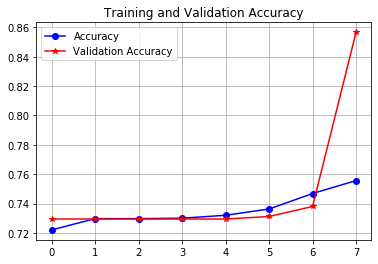

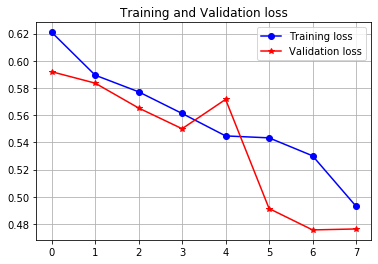

In [14]:
plt.plot(epochs,acc,'bo-',label="Accuracy")
plt.plot(epochs,val_acc,'r*-',label="Validation Accuracy")
plt.title('Training and Validation Accuracy')
plt.grid()
plt.legend()

plt.figure()
plt.plot(epochs,loss,'bo-',label="Training loss")
plt.plot(epochs,val_loss,'r*-',label="Validation loss")
plt.title('Training and Validation loss')
plt.grid()
plt.legend()

plt.show()

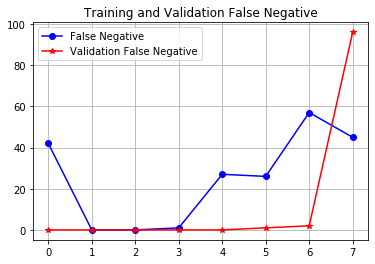

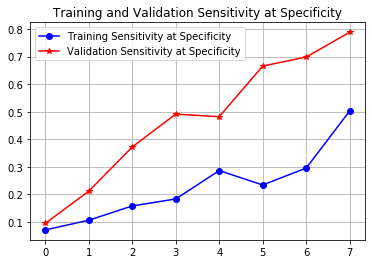

In [15]:
plt.figure()
plt.plot(epochs,fn,'bo-',label="False Negative")
plt.plot(epochs,val_fn,'r*-',label="Validation False Negative")
plt.title('Training and Validation False Negative')
plt.grid()
plt.legend()

plt.figure()
plt.plot(epochs,sas,'bo-',label="Training Sensitivity at Specificity")
plt.plot(epochs,val_sas,'r*-',label="Validation Sensitivity at Specificity")
plt.title('Training and Validation Sensitivity at Specificity')
plt.grid()
plt.legend()

plt.show()

Instructions for updating:
Please use Model.predict, which supports generators.


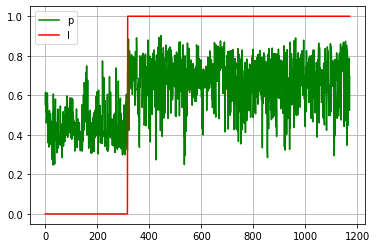

In [16]:
labels = test_generator.classes
predictions = model.predict_generator(test_generator).flatten()
plt.plot(predictions, label = 'p', color = 'g')
plt.plot(labels, label = 'l', color = 'r')
plt.legend()
plt.grid()

In [17]:
start_time = time.time()
predictions = model.predict_generator(test_generator)
print(f"Predicting time = {int((time.time() - start_time)/60)} minutes and {int((time.time() - start_time)%60)} seconds")

Predicting time = 0 minutes and 19 seconds


In [18]:
y_pred = 1.0*(predictions > 0.5).reshape(predictions.shape[0])

In [19]:
y_true = test_generator.classes

In [20]:
print(confusion_matrix(y_true, y_pred))
print(classification_report(y_true, y_pred))

[[236  81]
 [ 88 767]]
              precision    recall  f1-score   support

           0       0.73      0.74      0.74       317
           1       0.90      0.90      0.90       855

    accuracy                           0.86      1172
   macro avg       0.82      0.82      0.82      1172
weighted avg       0.86      0.86      0.86      1172



In [21]:
m1 = metrics.SensitivityAtSpecificity(0.9)
m1.update_state(y_true, predictions.reshape(predictions.shape[0]))
print(f"Sensitivity at Specificity = {m1.result().numpy()}")

Sensitivity at Specificity = 0.7976608276367188


In [22]:
m2 = metrics.FalseNegatives()
m2.update_state(y_true, y_pred)
print(f"False negative = {m2.result().numpy()}")

False negative = 88.0


In [23]:
m3 = metrics.Accuracy()
m3.update_state(y_true, y_pred)
print(f"Accuracy = {m3.result().numpy()}")

Accuracy = 0.855802059173584


In [24]:
fbeta_sklearn = fbeta_score(y_true, y_pred, beta=2)
print(f"F2 score = {fbeta_sklearn}")

F2 score = 0.8985473289597002


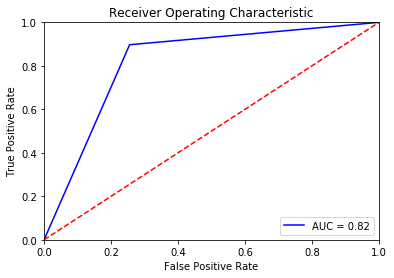

In [25]:
fpr, tpr, threshold = roc_curve(y_true,y_pred)
roc_auc = auc(fpr, tpr)
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

# Model 1 with weight

In [26]:
from sklearn.utils import class_weight

In [27]:
weights = class_weight.compute_class_weight('balanced',np.unique(train_generator.classes),train_generator.classes)
print(weights)

[1.85036881 0.68513461]


In [28]:
c_w = {0:weights[0],1:weights[1]}

In [29]:
model = models.Sequential()
model.add(layers.Conv2D(32,(3,3),activation = 'relu', input_shape = (150,150,3)))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(32,(3,3),activation = 'relu'))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(32,(3,3),activation = 'relu'))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(32,(3,3),activation = 'relu'))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Flatten())
model.add(layers.Dense(512,activation='relu'))
model.add(layers.Dense(1,activation='sigmoid'))

# model.summary()

In [30]:
model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr = 1e-4),
              metrics = [metrics.FalseNegatives(),metrics.SensitivityAtSpecificity(0.9),'acc']
             )

In [31]:
start_time = time.time()
history2 = model.fit_generator(train_generator,
                              steps_per_epoch = 8,
                              verbose = 0,
                              epochs = 8,
                              validation_data = validation_generator,
                              validation_steps = 4,
                              class_weight=c_w
            )
print(f"Training time = {int((time.time() - start_time)/60)} minutes and {int((time.time() - start_time)%60)} seconds")
#model.save('case2_run_1.h5')

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Training time = 16 minutes and 38 seconds


In [32]:
history2.history.keys()

dict_keys(['loss', 'false_negatives_2', 'sensitivity_at_specificity_2', 'acc', 'val_loss', 'val_false_negatives_2', 'val_sensitivity_at_specificity_2', 'val_acc'])

In [33]:
loss = history2.history['loss']
fn = history2.history['false_negatives_2']
acc = history2.history['acc']
sas = history2.history['sensitivity_at_specificity_2']
val_loss = history2.history['val_loss']
val_fn = history2.history['val_false_negatives_2']
val_acc = history2.history['val_acc']
val_sas = history2.history['val_sensitivity_at_specificity_2']
epochs = range(len(acc))

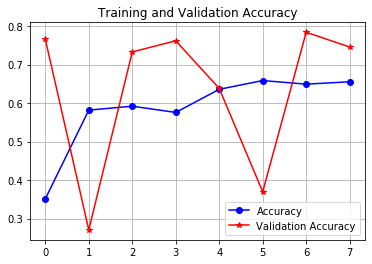

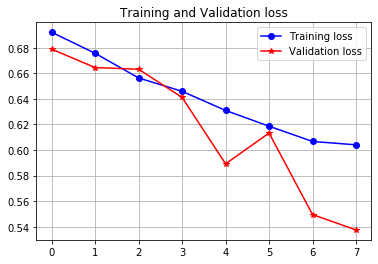

In [34]:
plt.plot(epochs,acc,'bo-',label="Accuracy")
plt.plot(epochs,val_acc,'r*-',label="Validation Accuracy")
plt.title('Training and Validation Accuracy')
plt.grid()
plt.legend()

plt.figure()
plt.plot(epochs,loss,'bo-',label="Training loss")
plt.plot(epochs,val_loss,'r*-',label="Validation loss")
plt.title('Training and Validation loss')
plt.grid()
plt.legend()

plt.show()

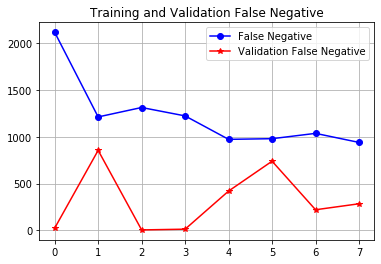

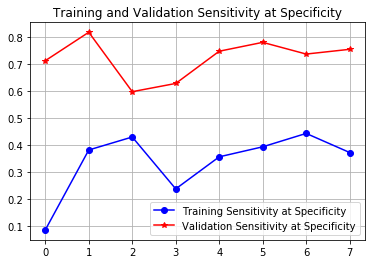

In [35]:
plt.figure()
plt.plot(epochs,fn,'bo-',label="False Negative")
plt.plot(epochs,val_fn,'r*-',label="Validation False Negative")
plt.title('Training and Validation False Negative')
plt.grid()
plt.legend()

plt.figure()
plt.plot(epochs,sas,'bo-',label="Training Sensitivity at Specificity")
plt.plot(epochs,val_sas,'r*-',label="Validation Sensitivity at Specificity")
plt.title('Training and Validation Sensitivity at Specificity')
plt.grid()
plt.legend()

plt.show()

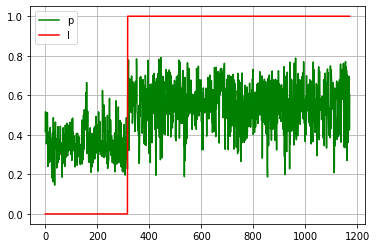

In [36]:
labels = test_generator.classes
predictions = model.predict_generator(test_generator).flatten()
plt.plot(predictions, label = 'p', color = 'g')
plt.plot(labels, label = 'l', color = 'r')
plt.legend()
plt.grid()

In [37]:
start_time = time.time()
predictions = model.predict_generator(test_generator)

In [38]:
y_pred = 1.0*(predictions > 0.5).reshape(predictions.shape[0])
print(f"Predicting time = {int((time.time() - start_time)/60)} minutes and {int((time.time() - start_time)%60)} seconds")

Predicting time = 0 minutes and 19 seconds


In [39]:
y_true = test_generator.classes

In [40]:
print(confusion_matrix(y_true, y_pred))
print(classification_report(y_true, y_pred))

[[302  15]
 [241 614]]
              precision    recall  f1-score   support

           0       0.56      0.95      0.70       317
           1       0.98      0.72      0.83       855

    accuracy                           0.78      1172
   macro avg       0.77      0.84      0.76      1172
weighted avg       0.86      0.78      0.79      1172



In [41]:
m1 = metrics.SensitivityAtSpecificity(0.9)
m1.update_state(y_true, predictions.reshape(predictions.shape[0]))
print(f"Sensitivity at Specificity = {m1.result().numpy()}")

Sensitivity at Specificity = 0.784795343875885


In [42]:
m2 = metrics.FalseNegatives()
m2.update_state(y_true, y_pred)
print(f"False negative = {m2.result().numpy()}")

False negative = 241.0


In [43]:
m3 = metrics.Accuracy()
m3.update_state(y_true, y_pred)
print(f"Accuracy = {m3.result().numpy()}")

Accuracy = 0.7815699577331543


In [44]:
fbeta_sklearn = fbeta_score(y_true, y_pred, beta=2)
print(f"F2 score = {fbeta_sklearn}")

F2 score = 0.7582119041738702


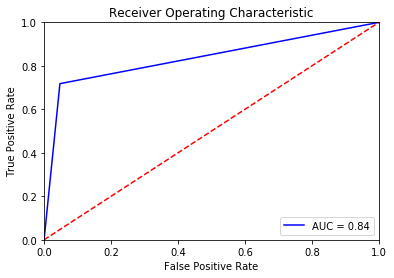

In [45]:
fpr, tpr, threshold = roc_curve(y_true,y_pred)
roc_auc = auc(fpr, tpr)
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()